In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [166]:
stk_list = pd.read_csv("data/stock_list.csv")
stk_list = stk_list[~stk_list['industry_category'].isin(['ETF','ETN','上櫃指數股票型基金(ETF)','受益證券','指數投資證券(ETN)','其他','所有證券','創新板股票','存託憑證', 'Index', '大盤'])]
stk_list = stk_list[stk_list['type'].isin(['twse'])]
stk_list = stk_list[stk_list['stock_id'].apply(lambda x: len(x) == 4)]
stk_list

,industry_category,stock_id,stock_name,type,date
355,水泥工業,1101,台泥,twse,2023-12-14
357,水泥工業,1102,亞泥,twse,2023-12-14
358,水泥工業,1103,嘉泥,twse,2023-12-14
359,水泥工業,1104,環泥,twse,2023-12-14
361,水泥工業,1108,幸福,twse,2023-12-14
...,...,...,...,...,...
3165,觀光事業,9943,好樂迪,twse,2023-06-29
3166,觀光餐旅,9943,好樂迪,twse,2023-12-14
3169,建材營造,9946,三發地產,twse,2023-12-14
3174,綠能環保,9955,佳龍,twse,2023-12-14


In [167]:
stock_ids = stk_list['stock_id'].unique()

#load data
df_trading = pd.read_csv('data/all_stock_close_price_from2022-12-23to2023-12-24.csv')
df_broker = pd.read_csv('data/9217_from2022-12-23to2023-12-24_trader_trading.csv')
print(len(df_trading))

# 過濾出要分析的股票 而不是ETF等等
df_broker = df_broker[df_broker['stock_id'].isin(stock_ids)]

# 按日期分組，選取每天買進量前二十的股票
# top20_buys_daily = df_broker.groupby('date').apply(lambda x: x.sort_values('buy', ascending=False).head(20)).reset_index(drop=True)

buys_daily = df_broker.groupby('date').apply(lambda x: x.sort_values('buy', ascending=False)).reset_index(drop=True)
print(len(buys_daily))

# 計算每支股票每天的總買進量
broker_buy_sum = buys_daily.groupby(['stock_id', 'date'])['buy'].sum().reset_index()

# 合併到每日成交資料中
df_combined = pd.merge(df_trading, broker_buy_sum, on=['stock_id', 'date'], how='left')
print(len(df_combined))

# 計算買進比例
df_combined['buy_ratio'] = df_combined['buy'] / df_combined['Trading_Volume']
df_combined[df_combined['buy_ratio'] > 0.1]

8620927
276972
8620927


,date,stock_id,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover,buy,buy_ratio
23571,2022-12-23,2109,25124,361729,14.45,14.45,14.35,14.40,0.00,43,4000.0,0.159210
56254,2022-12-26,6141,72000,1384300,19.05,19.50,19.05,19.50,0.30,55,27000.0,0.375000
63246,2022-12-26,8940,52645,861145,16.30,16.45,16.30,16.35,0.20,44,8000.0,0.151961
87005,2022-12-27,2397,19241,1135671,58.80,59.10,58.80,59.10,0.50,16,6000.0,0.311834
87401,2022-12-27,3416,41419,3448201,83.00,83.40,83.00,83.40,0.20,49,10000.0,0.241435
...,...,...,...,...,...,...,...,...,...,...,...,...
8015107,2023-12-04,3605,247513,7704001,30.85,31.40,30.80,31.20,0.35,218,25000.0,0.101005
8141747,2023-12-07,3130,13693,2888698,211.00,211.00,210.50,211.00,0.00,35,2000.0,0.146060
8354180,2023-12-14,6141,42835,695433,16.25,16.30,16.20,16.30,0.05,50,6000.0,0.140072
8449331,2023-12-18,9918,7071,289032,41.00,41.00,40.70,40.70,-0.35,20,1000.0,0.141423


In [168]:
# 對日期進行排序，以便計算隔天價格
df_combined.sort_values(by=['stock_id', 'date'], inplace=True)
df_combined
# 計算隔天的股價變化
df_combined['next_day_close'] = df_combined.groupby('stock_id')['close'].shift(-1)
df_combined['price_change'] = df_combined['next_day_close'] - df_combined['close']
df_combined['price_change_percentage'] = (df_combined['price_change'] / df_combined['close']) * 100

#list the next_day_price_change > +- 10%
# filter out the outlier
df_combined = df_combined[df_combined['price_change_percentage'].apply(lambda x: abs(x) < 10)]


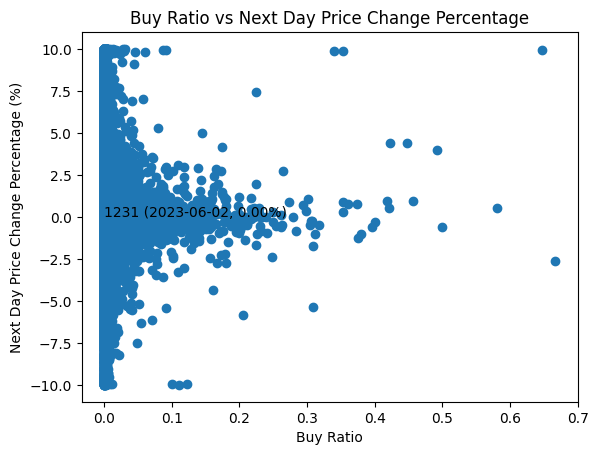

In [169]:
# 繪製散點圖
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_percentage'])

# 隨機選擇部分點進行標注
sampled_points = df_combined.sample(n=20)
for index, row in sampled_points.iterrows():
    plt.annotate(f"{row['stock_id']} ({row['date']}, {row['price_change_percentage']:.2f}%)",
                 (row['buy_ratio'], row['price_change_percentage']))

plt.xlabel('Buy Ratio')
plt.ylabel('Next Day Price Change Percentage (%)')
plt.title('Buy Ratio vs Next Day Price Change Percentage')
plt.show()

True
False


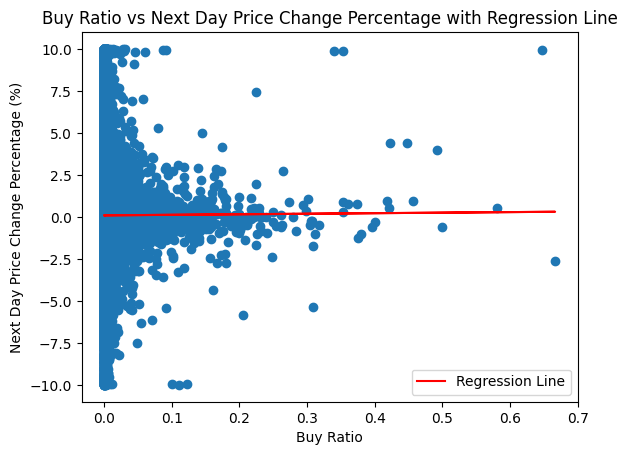

In [170]:

print(df_combined['buy_ratio'].isnull().any())
print(df_combined['price_change_percentage'].isnull().any())

# 移除NaN值
df_combined = df_combined.dropna(subset=['buy_ratio', 'price_change_percentage'])
# 使用numpy計算線性回歸的參數
slope, intercept = np.polyfit(df_combined['buy_ratio'], df_combined['price_change_percentage'], 1)


# 移除NaN值
df_combined = df_combined.dropna(subset=['buy_ratio', 'price_change_percentage'])
# 繪製散點圖
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_percentage'])

# 繪製回歸線
x = np.array(df_combined['buy_ratio'])
plt.plot(x, intercept + slope * x, color='red', label='Regression Line')

# 添加標籤和標題
plt.xlabel('Buy Ratio')
plt.ylabel('Next Day Price Change Percentage (%)')
plt.title('Buy Ratio vs Next Day Price Change Percentage with Regression Line')
plt.legend()

# 顯示圖形
plt.show()


In [171]:
# 假设 df_combined 已经加载且包含所需的股票数据

# 确保日期格式正确并排序
df_combined['date'] = pd.to_datetime(df_combined['date'])
df_combined.sort_values(by=['stock_id', 'date'], inplace=True)

# 计算连续几天的股价变动百分比
for i in range(1, 6):
    df_combined[f'next_day_{i}_close'] = df_combined.groupby('stock_id')['close'].shift(-i)
    df_combined[f'price_change_day_{i}'] = (df_combined[f'next_day_{i}_close'] - df_combined['close']) / df_combined['close'] * 100

# 过滤超出阈值的数据
df_combined = df_combined[df_combined['price_change_day_1'].abs() <= 10]
df_combined = df_combined[df_combined['price_change_day_2'].abs() <= 10 * 1.1] 
df_combined = df_combined[df_combined['price_change_day_3'].abs() <= 10 * 1.1 ** 2]
df_combined = df_combined[df_combined['price_change_day_4'].abs() <= 10 * 1.1 ** 3]
df_combined = df_combined[df_combined['price_change_day_5'].abs() <= 10 * 1.1 ** 4]


# 显示结果
print(df_combined)


              date stock_id  Trading_Volume  Trading_money    open     max  \
23295   2022-12-23     1101        23483856      804299895   34.15   34.60   
54972   2022-12-26     1101        12361474      424140679   34.35   34.45   
86644   2022-12-27     1101        11426803      394169733   34.55   34.70   
118300  2022-12-28     1101        14092727      482086632   34.15   34.35   
150025  2022-12-29     1101        13483783      456027492   34.25   34.25   
...            ...      ...             ...            ...     ...     ...   
8194781 2023-12-08     9958         5615336     1026727125  183.00  185.00   
8237047 2023-12-11     9958         5627796     1005647950  183.00  183.50   
8279448 2023-12-12     9958         4877111      887945491  179.50  184.50   
8321959 2023-12-13     9958         5062733      925013081  183.00  185.50   
8364546 2023-12-14     9958         8812311     1638463715  181.50  189.00   

            min   close  spread  Trading_turnover  ...  next_da

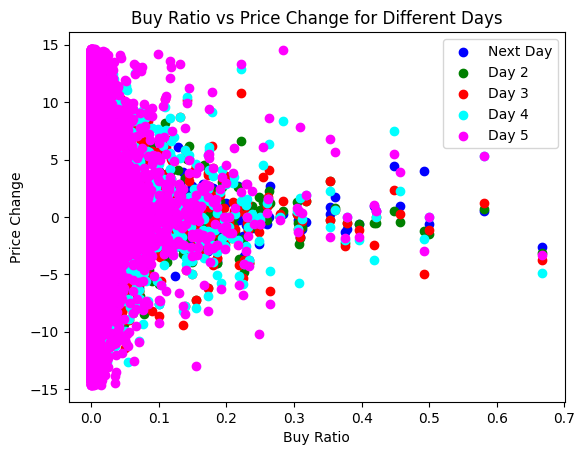

In [172]:
# 繪製散點圖
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_day_1'], color='blue', label='Next Day')
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_day_2'], color='green', label='Day 2')
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_day_3'], color='red', label='Day 3')
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_day_4'], color='cyan', label='Day 4')
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_day_5'], color='magenta', label='Day 5')

# 添加標籤和標題
plt.xlabel('Buy Ratio')
plt.ylabel('Price Change')
plt.title('Buy Ratio vs Price Change for Different Days')
plt.legend()

# 顯示圖形
plt.show()

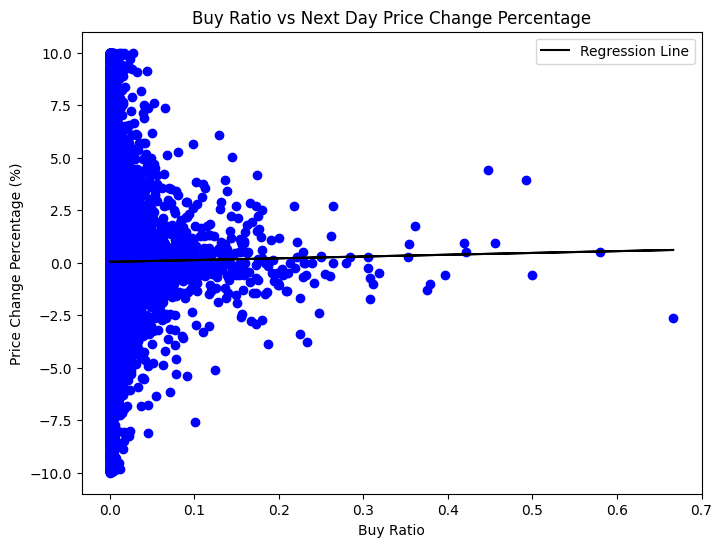

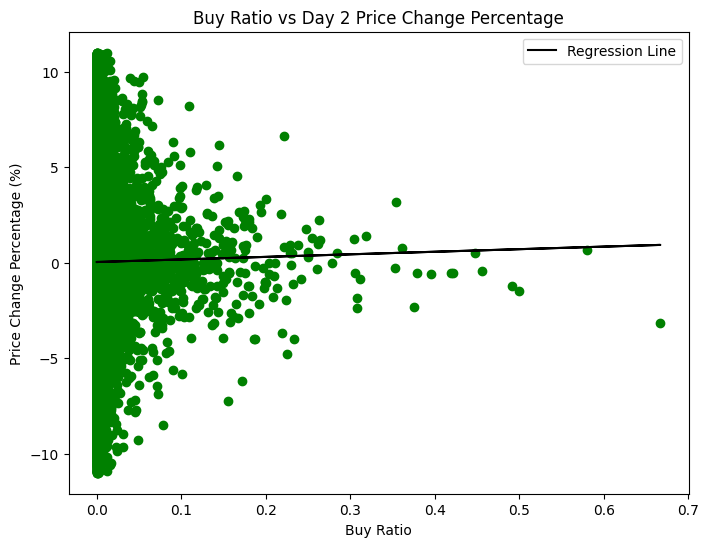

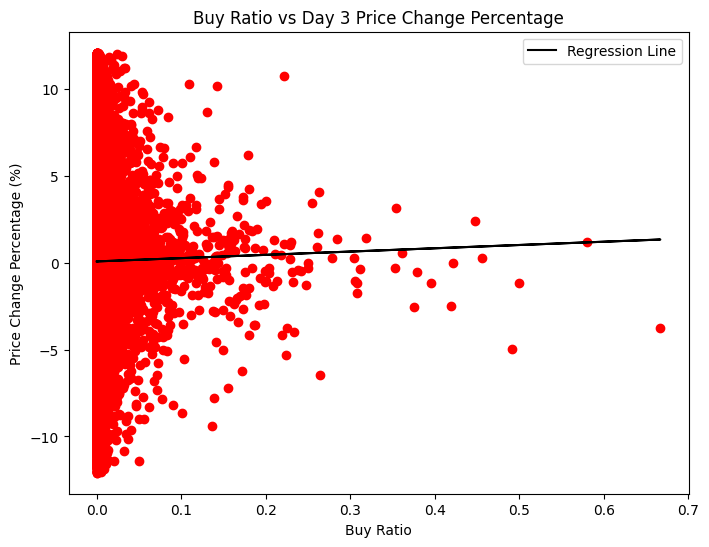

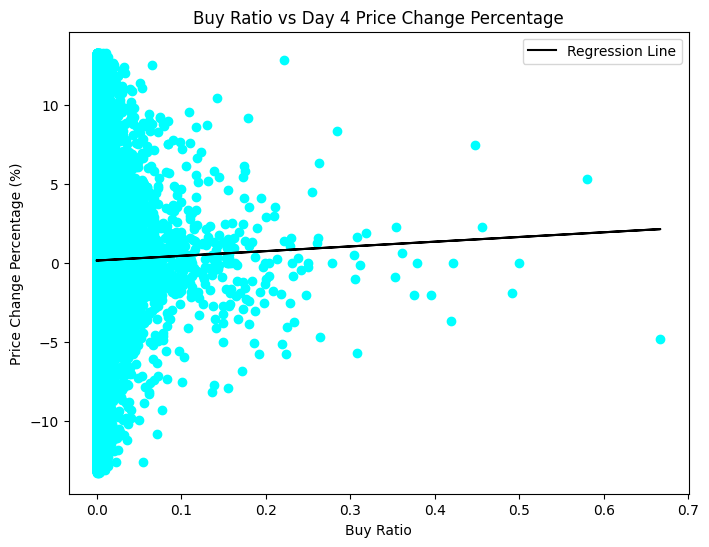

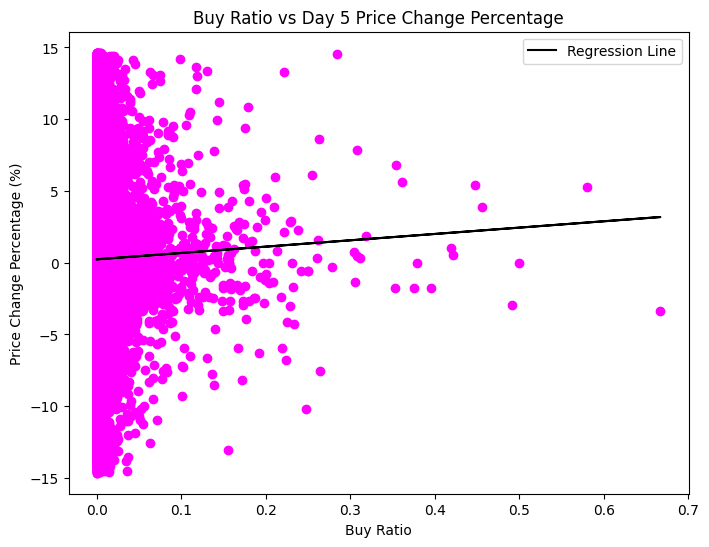

In [173]:
# 計算回歸線參數並繪製散點圖及回歸線的函數
def plot_with_regression(x, y, title, color):
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color=color)

    # 計算回歸線參數
    slope, intercept = np.polyfit(x, y, 1)
    plt.plot(x, slope * x + intercept, color='black', label='Regression Line')

    plt.xlabel('Buy Ratio')
    plt.ylabel('Price Change Percentage (%)')
    plt.title(title)
    plt.legend()
    plt.show()

# 去除含有NaN值的行
df_combined.dropna(subset=['price_change_day_1', 'price_change_day_2', 'price_change_day_3', 'price_change_day_4', 'price_change_day_5'], inplace=True)

# 繪製每一天的散點圖和回歸線
plot_with_regression(df_combined['buy_ratio'], df_combined['price_change_day_1'], 'Buy Ratio vs Next Day Price Change Percentage', 'blue')
plot_with_regression(df_combined['buy_ratio'], df_combined['price_change_day_2'], 'Buy Ratio vs Day 2 Price Change Percentage', 'green')
plot_with_regression(df_combined['buy_ratio'], df_combined['price_change_day_3'], 'Buy Ratio vs Day 3 Price Change Percentage', 'red')
plot_with_regression(df_combined['buy_ratio'], df_combined['price_change_day_4'], 'Buy Ratio vs Day 4 Price Change Percentage', 'cyan')
plot_with_regression(df_combined['buy_ratio'], df_combined['price_change_day_5'], 'Buy Ratio vs Day 5 Price Change Percentage', 'magenta')

零假設（H0）是：當凱基松山這間券商買進量佔當天總成交量的2%以上時，對該股票接下來五天的平均股價沒有顯著影響

In [174]:
df_combined['avg_price_change_5d'] = df_combined[['price_change_day_1','price_change_day_2', 'price_change_day_3', 'price_change_day_4', 'price_change_day_5']].mean(axis=1)


# 使用.loc[]來避免SettingWithCopyWarning
df_high_buy = df_combined[df_combined['buy_ratio'] >= 0.02].copy()
df_high_buy.loc[:, 'avg_price_change_5d'] = (df_high_buy[['price_change_day_1','price_change_day_2', 'price_change_day_3', 'price_change_day_4', 'price_change_day_5']].sum(axis=1)) / 4
df_combined

,date,stock_id,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover,...,price_change_day_1,next_day_2_close,price_change_day_2,next_day_3_close,price_change_day_3,next_day_4_close,price_change_day_4,next_day_5_close,price_change_day_5,avg_price_change_5d
23295,2022-12-23,1101,23483856,804299895,34.15,34.60,33.80,34.05,-0.40,10819,...,1.027900,34.30,0.734214,34.30,0.734214,33.70,-1.027900,33.65,-1.174743,0.058737
54972,2022-12-26,1101,12361474,424140679,34.35,34.45,34.10,34.40,0.35,5761,...,-0.290698,34.30,-0.290698,33.70,-2.034884,33.65,-2.180233,33.50,-2.616279,-1.482558
86644,2022-12-27,1101,11426803,394169733,34.55,34.70,34.30,34.30,-0.10,6494,...,0.000000,33.70,-1.749271,33.65,-1.895044,33.50,-2.332362,33.50,-2.332362,-1.661808
118300,2022-12-28,1101,14092727,482086632,34.15,34.35,33.95,34.30,0.00,5921,...,-1.749271,33.65,-1.895044,33.50,-2.332362,33.50,-2.332362,34.45,0.437318,-1.574344
150025,2022-12-29,1101,13483783,456027492,34.25,34.25,33.70,33.70,-0.60,6848,...,-0.148368,33.50,-0.593472,33.50,-0.593472,34.45,2.225519,34.25,1.632047,0.504451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8194781,2023-12-08,9958,5615336,1026727125,183.00,185.00,180.00,182.50,0.50,3979,...,-1.917808,181.00,-0.821918,180.00,-1.369863,186.50,2.191781,172.00,-5.753425,-1.534247
8237047,2023-12-11,9958,5627796,1005647950,183.00,183.50,176.00,179.00,-3.50,10760,...,1.117318,180.00,0.558659,186.50,4.189944,172.00,-3.910615,181.50,1.396648,0.670391
8279448,2023-12-12,9958,4877111,887945491,179.50,184.50,179.50,181.00,2.00,3683,...,-0.552486,186.50,3.038674,172.00,-4.972376,181.50,0.276243,181.50,0.276243,-0.386740
8321959,2023-12-13,9958,5062733,925013081,183.00,185.50,180.00,180.00,-1.00,8060,...,3.611111,172.00,-4.444444,181.50,0.833333,181.50,0.833333,178.00,-1.111111,-0.055556


In [176]:
from scipy import stats

# 提取兩組數據：買進比例大於等於２%的樣本和所有樣本
group1 = df_high_buy['avg_price_change_5d']
group2 = df_combined['avg_price_change_5d']

# 列出樣本數
group1_count = len(group1)
group2_count = len(group2)
print("買進比例大於等於2%的樣本數:", group1_count)
print("所有樣本數:", group2_count)

# 進行t檢定
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
print("零假設（H0）是：當凱基松山這間券商買進量佔當天總成交量的2%以上時，對該股票接下來五天的平均股價沒有顯著影響")
print("t統計量:", t_stat)
print("p值:", p_value)

買進比例大於等於2%的樣本數: 1719
所有樣本數: 72813
t統計量: 3.5332804925005723
p值: 0.0004208808293682534


樣本數：

買進比例大於等於1%的樣本數為3845。
所有樣本的總數為80367。
t檢定統計量：5.43176389273512

p值：5.8968450291081516e-08

解讀結果
t統計量：t統計量的值5.43顯示兩組數據均值之間存在較大的差異。

p值：p值非常小（約為0.000000059），遠小於常用的顯著性水平（如0.05或0.01）。這表示您觀察到的數據或更極端情況在零假設為真時發生的概率非常低。

結論
這個非常小的p值意味著您可以拒絕零假設。換句話說，有足夠的證據表明買進比例大於等於1%的股票在接下來五天的平均股價變動上與其他股票存在顯著差異。這可能表示當券商的買進量占較大比例時，會對股票的短期表現產生影響。

注意事項
需要注意的是，雖然統計上顯著，但這並不一定意味著這種差異在實際情況中具有重要的經濟意義。
這些結果僅基於過去的數據，未來的市場表現可能會有所不同。
此外，這種統計測試不能證明因果關係，僅能指出兩組數據之間的關聯性。其他因素也可能影響股票價格。